# Sheet 6

In [81]:
# Import packages
import pandas as pd
#from numpy.linalg import inv
##from scipy.optimize import root_scalar
from scipy.optimize import fsolve
import torch as tc
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

## Understanding an RNN
![Flowchart of RNN](understand_rnn.jpeg)

## Training the RNN

**Complete the template for model and training loop**

In [82]:
# TASK 2: Set the hidden size (dimension of z_t)
# Try different values: start with 2, then 4, 8, 16...
# Find the minimum number that works well
hidden_size = 2  # TODO: Replace with your choice

# Training parameters
epochs = 1500
learning_rate = 0.01 # TODO: Try different values

Data shape: torch.Size([41, 2])
Observation size: 2
Time steps: 41


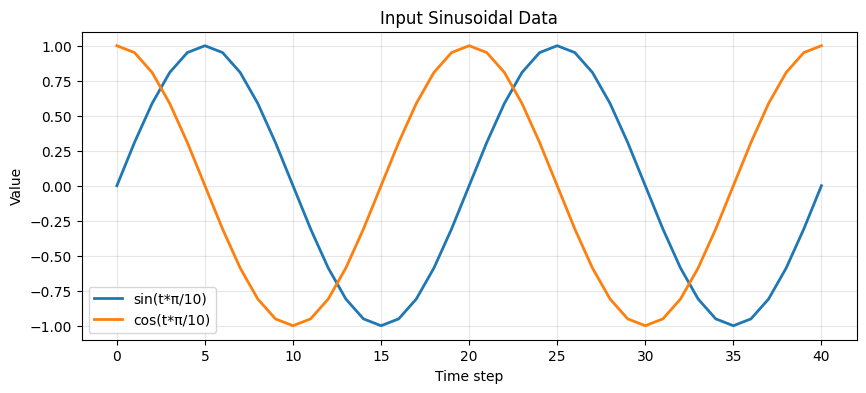

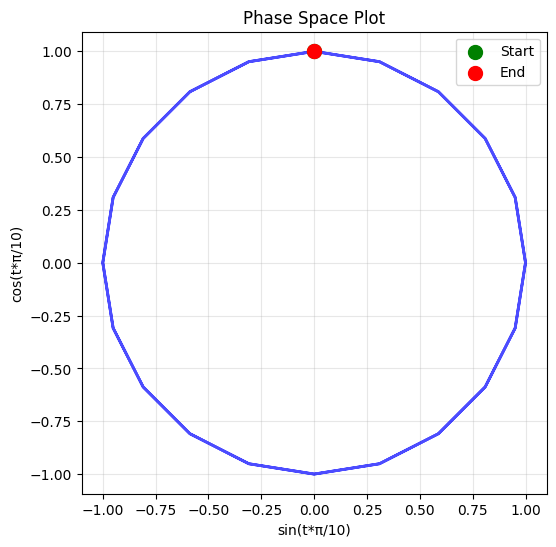

In [83]:
#%% DATA LOADING AND VISUALIZATION

# Load the sinusoidal data: x_t = [sin(t*π/10), cos(t*π/10)] for t=0,...,40
data = tc.load('sinus.pt')
observation_size = data.shape[1]  # Should be 2 (sin and cos components)

print(f"Data shape: {data.shape}")
print(f"Observation size: {observation_size}")
print(f"Time steps: {data.shape[0]}")

# Plot the input data
plt.figure(figsize=(10, 4))
plt.plot(data[:, 0], label='sin(t*π/10)', linewidth=2)
plt.plot(data[:, 1], label='cos(t*π/10)', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(data[:, 0], data[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(data[0, 0], data[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(data[-1, 0], data[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [84]:
#%% MODEL DEFINITION

class LatentRNN(nn.Module):
    """
    Recurrent Neural Network for learning dynamical systems
    
    Architecture:
    z_t = tanh(C * x_{t-1} + W * z_{t-1} + h)  # Hidden state update
    \hat{x}_t = B * z_t + c                    # Output generation
    """
    
    def __init__(self, obs_dim, latent_dim):
        super(LatentRNN, self).__init__()
        
        self.obs_dim = obs_dim        # Dimension of observations (2 for sin/cos)
        self.latent_dim = latent_dim  # Dimension of hidden state z_t
   
        # 1. Input-to-hidden transformation: U matrix and bias b # Input-to-hidden (C * x_{t-1} + h)
        self.input_to_hidden = nn.Linear(obs_dim, latent_dim)
        # 2. Hidden-to-hidden transformation: V matrix  # Hidden-to-hidden (W * z_{t-1})
        self.hidden_to_hidden = nn.Linear(latent_dim, latent_dim, bias=False)
        # 3. Hidden-to-output transformation: W matrix and bias c # Hidden-to-output (B * z_t + c)
        self.hidden_to_output = nn.Linear(latent_dim, obs_dim)
        
    def forward(self, time_series, h0):
        """
        Forward pass through the RNN
        
        Args:
            time_series: Input sequence of shape (seq_len, batch_size, obs_dim)
            h0: Initial hidden state of shape (1, batch_size, latent_dim)
            
        Returns:
            obs_output: Predicted observations of shape (seq_len, batch_size, obs_dim)
            h: Final hidden state of shape (1, batch_size, latent_dim)
        """
        
        # TASK 2: Implement the forward pass
        # The output should be predicted observations and the final hidden state
        # Hint: For each time step, update hidden state and generate output

        seq_len, batch_size, obs_dim = time_series.size()
        h = h0.squeeze(0)
        
        outputs = []
        for t in range(seq_len):
            x_t = time_series[t]
            h = tc.tanh(self.input_to_hidden(x_t) + self.hidden_to_hidden(h))
            x_hat = self.hidden_to_output(h)
            outputs.append(x_hat)

        obs_output = tc.stack(outputs, dim=0)
        return obs_output, h.unsqueeze(0)
    

# Initialize the model

model = LatentRNN(observation_size, hidden_size)
# Print model information
print(f"\nModel Architecture:")
print(f"- Observation dimension: {observation_size}")
print(f"- Hidden dimension: {hidden_size}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters())}")


Model Architecture:
- Observation dimension: 2
- Hidden dimension: 2
- Total parameters: 16


In [85]:
def train(model, learning_rate, moment=0, optimizer_function='SGD', print_loss=True, batch_size=1, batch_sequence_length=1):
    """
    Training function with configurable optimizers and mini-batching
    
    Students need to implement the missing parts marked with TODO comments.
    """
    
    # TODO: Implement optimizer selection
    # Create the appropriate optimizer based on optimizer_function parameter
    # Available options: 'SGD' (with momentum support) and 'ADAM'
    # Hint: Use optim.SGD() and optim.Adam() from tc.optim
    
    if optimizer_function == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=moment)
    elif optimizer_function == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_function}")
    
    # Use Mean Squared Error (MSE) loss for this regression task
    loss_function = nn.MSELoss()
    
    losses = []
    
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Optimizer: {optimizer_function}, LR: {learning_rate}, Batch size: {batch_size}, Sequence length: {batch_sequence_length}")
    
    for epoch in range(epochs):
        # Create a tensor of shape (1, batch_size, hidden_size) with random values (the hidden states)
        h0 = tc.zeros((1, batch_size, model.latent_dim))
        
        # Prepare full sequences (input and target)
        x = data[:-1]  # Input: all timesteps except the last
        y = data[1:]   # Target: all timesteps except the first
        
        # Initialize tensors to hold batch data of shape (batch_sequence_length, batch_size, observation_dim):
        X = tc.empty((batch_sequence_length, batch_size, model.obs_dim))
        Y = tc.empty((batch_sequence_length, batch_size, model.obs_dim))
        
        # For each element in the batch, sample a random subsequence from the data
        # The subsequence should start at a random index and have length batch_sequence_length
        # Make sure the random index doesn't exceed the data bounds
        
        for j in range(batch_size):
            # Sample a random starting index for the subsequence
            # Ensure: 0 <= ind <= len(x) - batch_sequence_length
            ind = tc.randint(0, len(x) - batch_sequence_length + 1, (1,)).item()
            
            # Extract subsequence and assign to batch tensors
            X[:, j, :] = x[ind: ind + batch_sequence_length]
            Y[:, j, :] = y[ind : ind + batch_sequence_length]
        
        # Forward pass
        # 1. Zero the gradients from previous iteration
        optimizer.zero_grad()
        # 2. Run the model forward pass with input X and initial hidden state h0
        output, _ = model.forward(X, h0)
        # 3. Calculate the loss between model output and target Y
        epoch_loss = loss_function(output, Y)
        
        # Backward pass and optimization step
        # 1. Compute gradients via backpropagation
        epoch_loss.backward()
        # 2. Update model parameters
        optimizer.step()
        
        # Store loss for plotting
        losses.append(epoch_loss.item())
        
        # Print progress
        if epoch % 10 == 0 and print_loss:
            print(f"Epoch: {epoch} loss {epoch_loss.item():.6f}")
    
    return losses

In [86]:
# Train the model
losses = train(model, learning_rate = learning_rate, moment=0, optimizer_function='SGD', print_loss=True, batch_size=5, batch_sequence_length=5) # TODO: input the right hyperparameters


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5
Epoch: 0 loss 0.625227
Epoch: 10 loss 1.054729
Epoch: 20 loss 0.792951
Epoch: 30 loss 0.646931
Epoch: 40 loss 0.503725
Epoch: 50 loss 0.463544
Epoch: 60 loss 0.554534
Epoch: 70 loss 0.469471
Epoch: 80 loss 0.448461
Epoch: 90 loss 0.496935
Epoch: 100 loss 0.446949
Epoch: 110 loss 0.363312
Epoch: 120 loss 0.250405
Epoch: 130 loss 0.343137
Epoch: 140 loss 0.336115
Epoch: 150 loss 0.236161
Epoch: 160 loss 0.317185
Epoch: 170 loss 0.250632
Epoch: 180 loss 0.267144
Epoch: 190 loss 0.316637
Epoch: 200 loss 0.302248
Epoch: 210 loss 0.322528
Epoch: 220 loss 0.274427
Epoch: 230 loss 0.310210
Epoch: 240 loss 0.246239
Epoch: 250 loss 0.258841
Epoch: 260 loss 0.233570
Epoch: 270 loss 0.214573
Epoch: 280 loss 0.228611
Epoch: 290 loss 0.187617
Epoch: 300 loss 0.276442
Epoch: 310 loss 0.277489
Epoch: 320 loss 0.293885
Epoch: 330 loss 0.224079
Epoch: 340 loss 0.279902
Epoch: 350 loss 0.297983
Epoch: 360 lo

**In the last section of the script, generate a freely predicted trajectory. Try to find the minimum number of hidden units in the RNN**

We start with dimensions 2

In [87]:
#%% MODEL EVALUATION AND PREDICTION

# Generate predictions for 5 times the original sequence length
prediction_length = 5 * data.shape[0]

with tc.no_grad():
    # Initialize hidden state and predictions tensor
    h = tc.zeros(1, 1, model.latent_dim)
    predictions = tc.empty((prediction_length, 2))
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)
    
    # Generate sequence autoregressively, i.e. freely by providing the output as input
    for i in range(prediction_length):
        # TODO: make predictions and use prediction as input
        output, h = model(input_, h)  
        predictions[i] =  output
        input_ = output

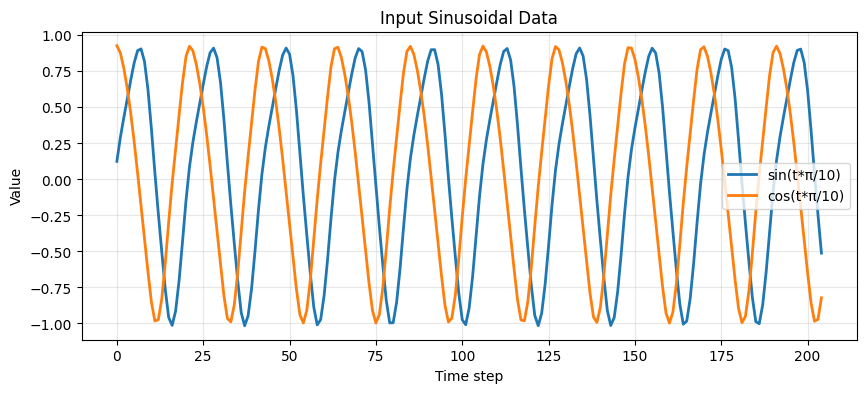

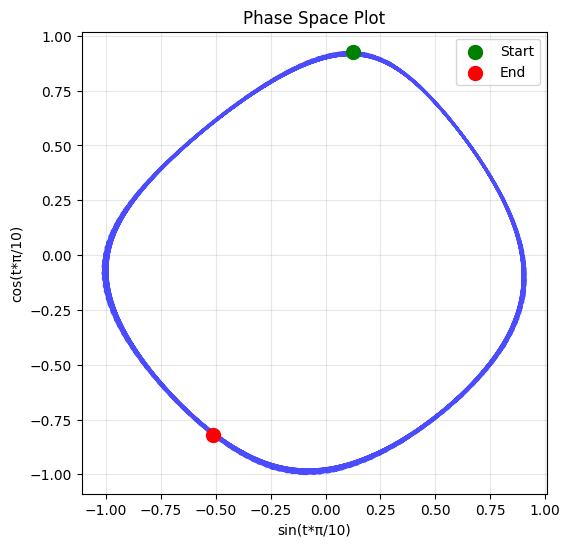

In [88]:
# Plot the prediction data
plt.figure(figsize=(10, 4))
plt.plot(predictions[:,0], label='sin(t*π/10)', linewidth=2)
plt.plot(predictions[:,1], label='cos(t*π/10)', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(predictions[:,0], predictions[:,1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

Looks okay, but we can do better. We now create a function so that we can find the minimal number of hidden units

In [ ]:
def num_hid_units(num, learning_rate = learning_rate):
    model = LatentRNN(observation_size, num)
    losses = train(model, learning_rate = learning_rate, moment=0, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
    prediction_length = 5 * data.shape[0]

    with tc.no_grad():
        # Initialize hidden state and predictions tensor
        h = tc.zeros(1, 1, model.latent_dim)
        predictions = tc.empty((prediction_length, 2))
        
        # Start with first data point
        input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)
        
        # Generate sequence autoregressively, i.e. freely by providing the output as input
        for i in range(prediction_length):
            # TODO: make predictions and use prediction as input
            output, h = model(input_, h)  
            predictions[i] =  output
            input_ = output
    
    # Plot the prediction data
    plt.figure(figsize=(10, 4))
    plt.plot(predictions[:,0], label='sin(t*π/10)', linewidth=2)
    plt.plot(predictions[:,1], label='cos(t*π/10)', linewidth=2)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f"Latent dimension: {num}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot phase space (sin vs cos)
    plt.figure(figsize=(6, 6))
    plt.plot(predictions[:,0], predictions[:,1], 'b-', linewidth=2, alpha=0.7)
    plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
    plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
    plt.xlabel('sin(t*π/10)')
    plt.ylabel('cos(t*π/10)')
    plt.title(f"Latent dimension: {num}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


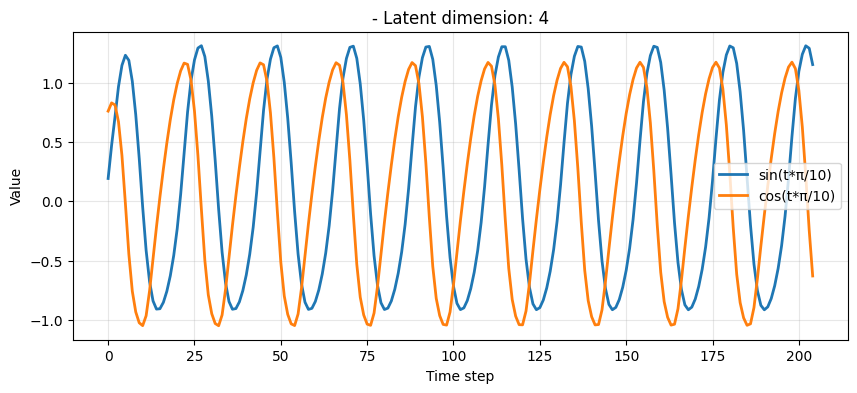

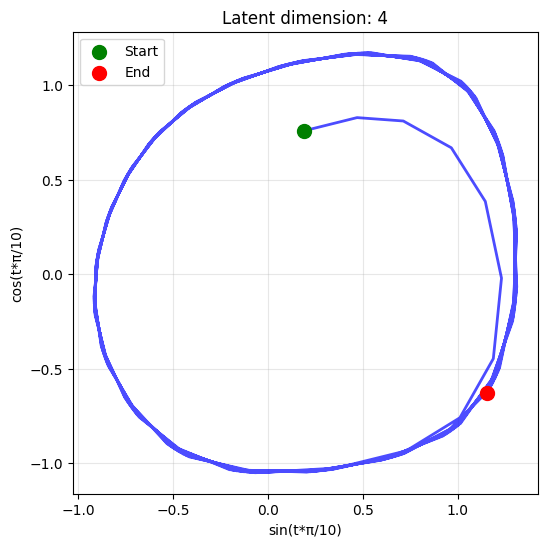


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


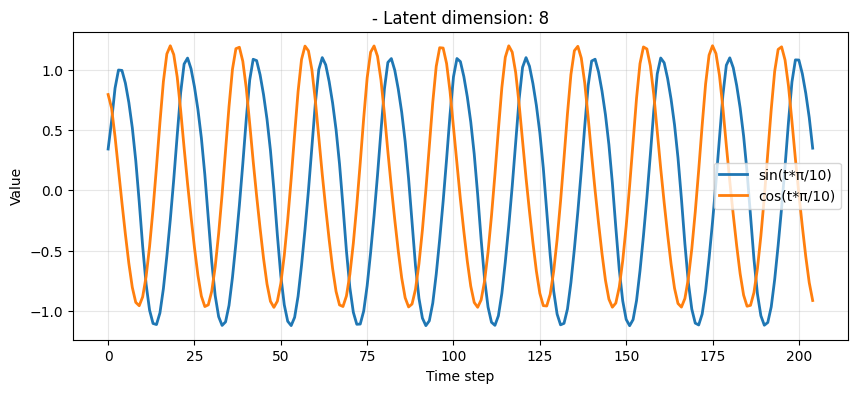

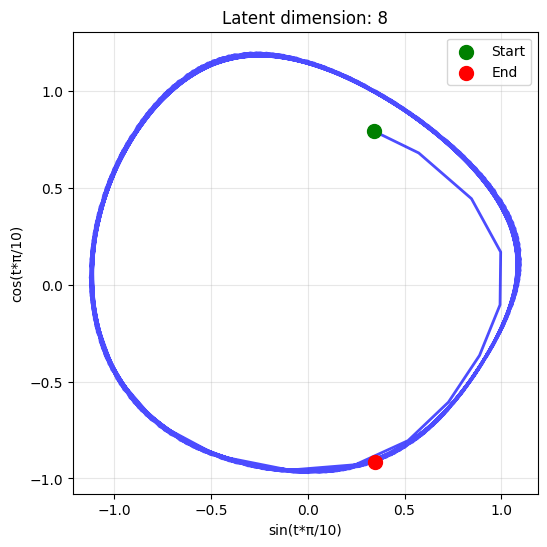


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


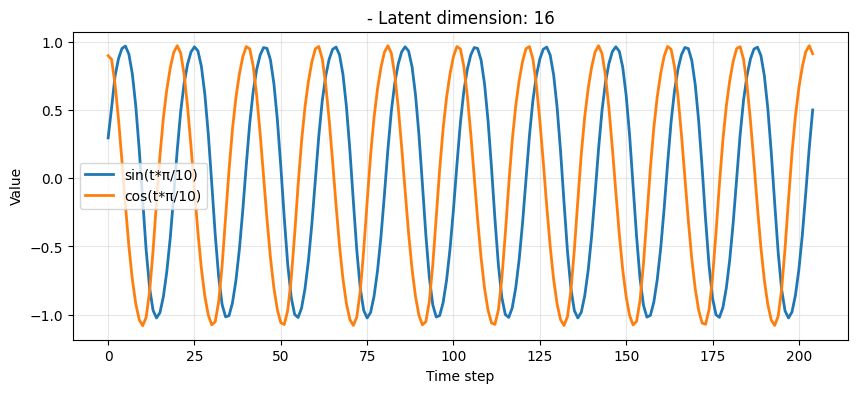

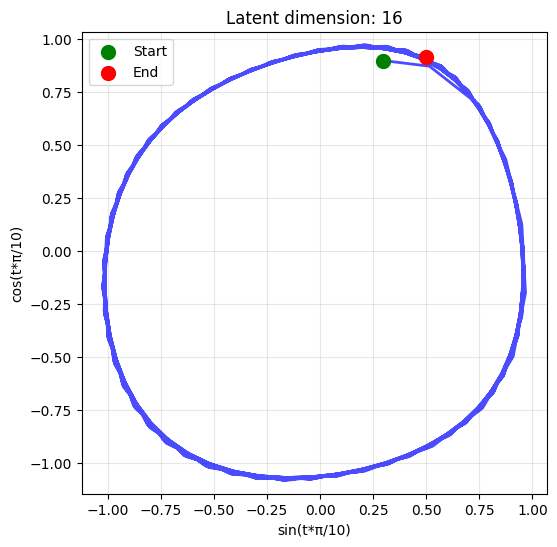


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


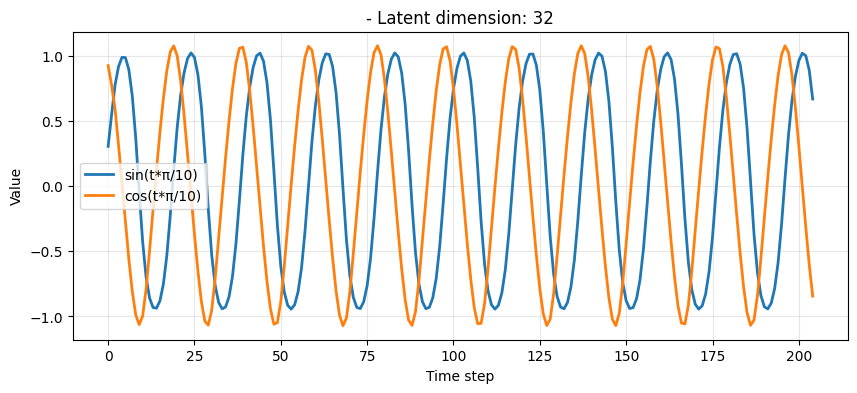

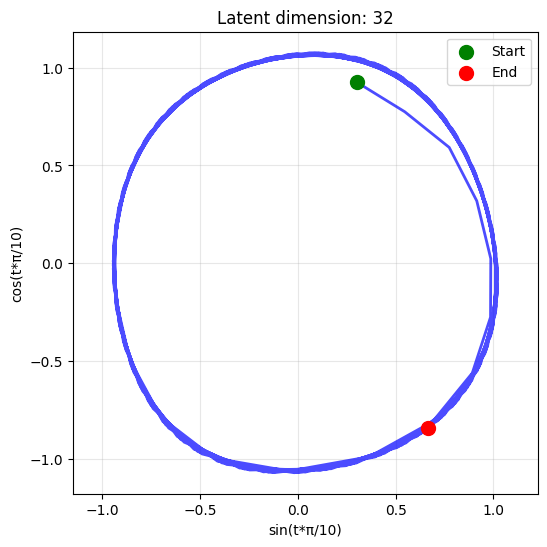


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


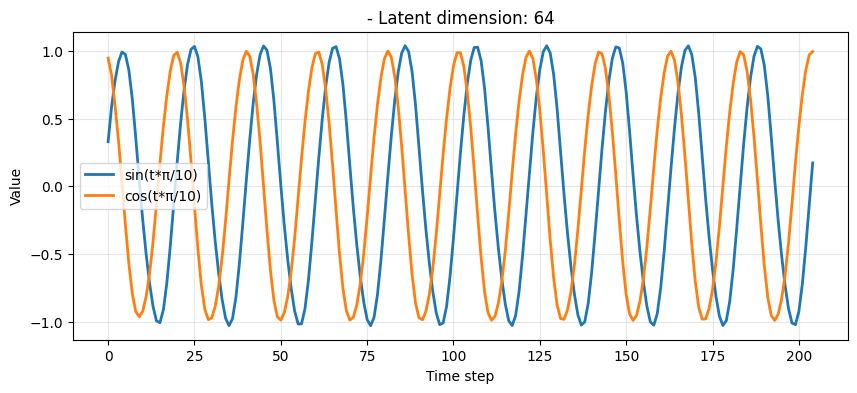

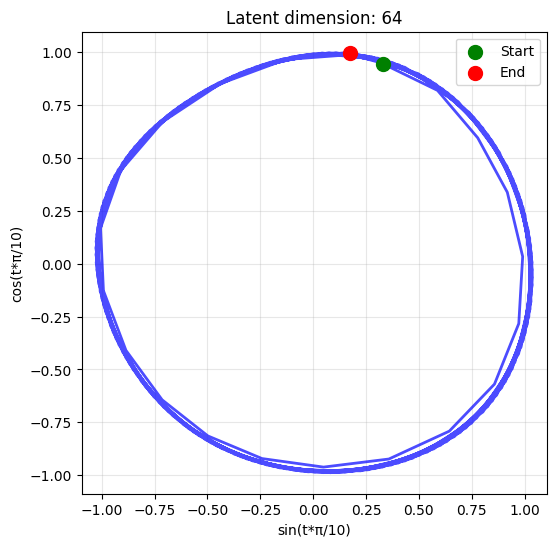


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


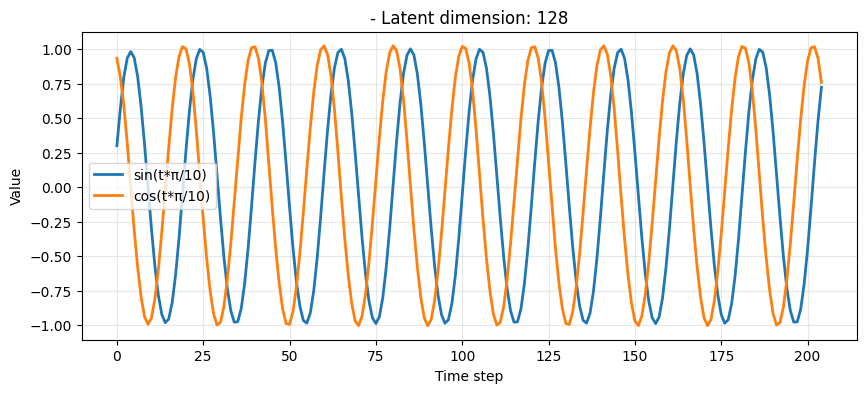

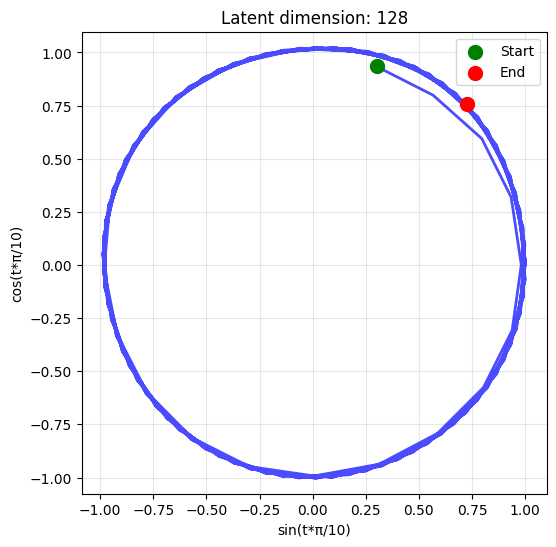


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


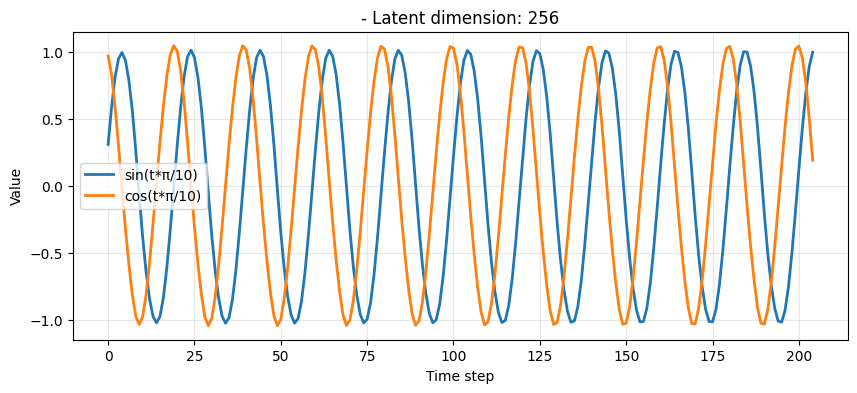

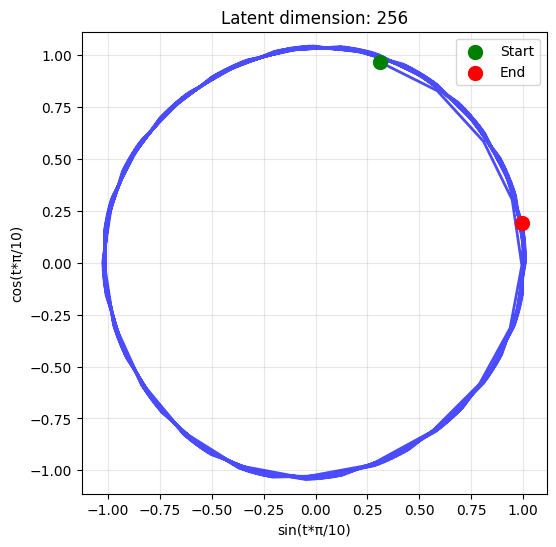

In [113]:
num_hid_units(4)
num_hid_units(8)
num_hid_units(16)
num_hid_units(32)
num_hid_units(64)
num_hid_units(128)
num_hid_units(256)

The reconstructions seem to improve in the dimensions of the latent state. With a latent dimension of 128, the reconstruction loooks quite good. 

## Optimizing Training

### Plot the losses as a function of number of gradient steps and vary the learning rate in gradient descent. How does the loss behave depending on the learning rate?



Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.0005, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.001, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.1, Batch size: 5, Sequence length: 5


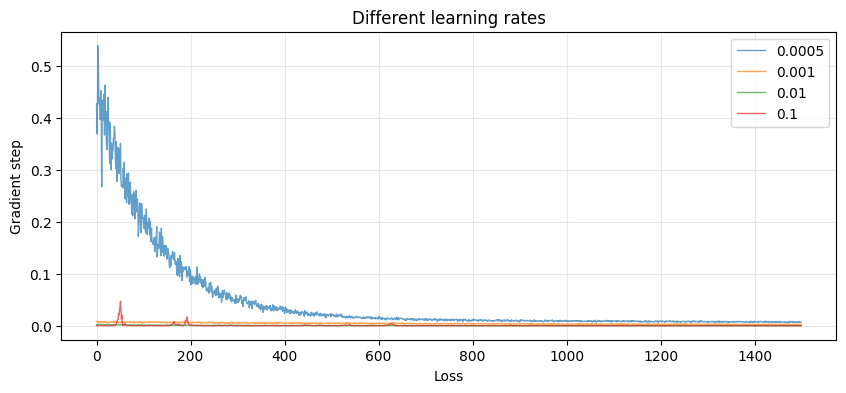

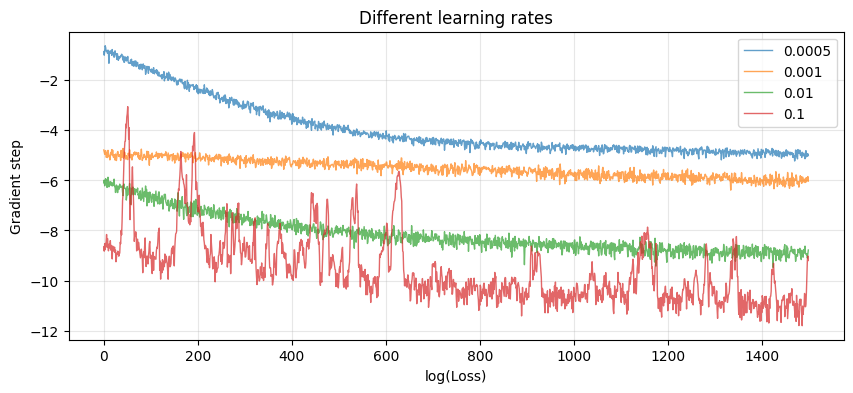

In [109]:
model_loss = LatentRNN(observation_size, 128)
losses00001 = train(model_loss, learning_rate = 0.0005, moment=0, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses0001 = train(model_loss, learning_rate = 0.001, moment=0, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses001 = train(model_loss, learning_rate = 0.01, moment=0, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses01 = train(model_loss, learning_rate = 0.1, moment=0, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)


plt.figure(figsize=(10, 4))
plt.plot(range(len(losses)),losses00001, linewidth=1, alpha=0.7, label='0.0005')
plt.plot(range(len(losses)),losses0001, linewidth=1, alpha=0.7, label='0.001')
plt.plot(range(len(losses)),losses001, linewidth=1, alpha=0.7, label='0.01')
plt.plot(range(len(losses)),losses01, linewidth=1, alpha=0.7, label ='0.1')
plt.xlabel('Loss')
plt.ylabel('Gradient step')
plt.title(f"Different learning rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(len(losses)),np.log(losses00001), linewidth=1, alpha=0.7, label='0.0005')
plt.plot(range(len(losses)),np.log(losses0001), linewidth=1, alpha=0.7, label='0.001')
plt.plot(range(len(losses)),np.log(losses001), linewidth=1, alpha=0.7, label='0.01')
plt.plot(range(len(losses)),np.log(losses01), linewidth=1, alpha=0.7, label ='0.1')
plt.xlabel('log(Loss)')
plt.ylabel('Gradient step')
plt.title(f"Different learning rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Both log(loss) and loss are plotted. From the plots we see that a learning rate of 0.0005 converges slower than the other three learning rates. 0.001 seems to converges fast. 0.01 seems to quickly converge, and not jump away. 0.1 jumps around a bit, and one could worry that is would not end in an optimum. 

### How do the dynamics change when the learning rate is adapted with momentum?

We do the same plots as before, now with momentum


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.0005, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.001, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.1, Batch size: 5, Sequence length: 5


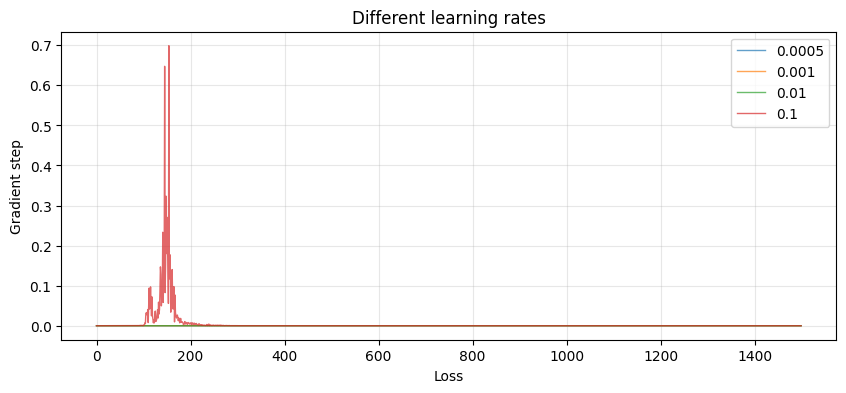

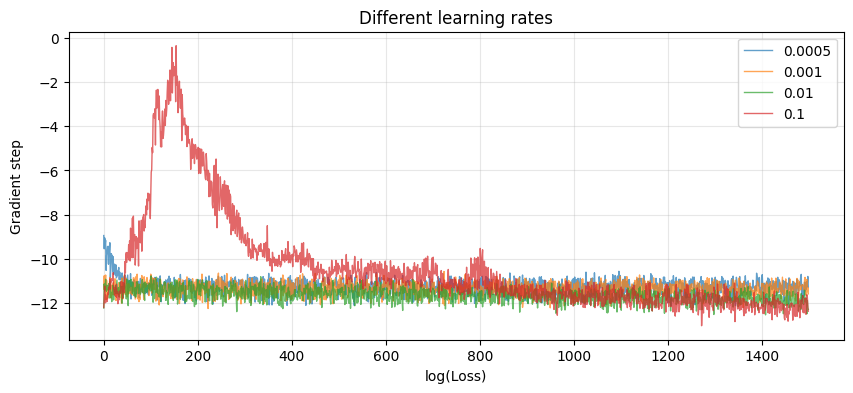

In [112]:
losses00001 = train(model_loss, learning_rate = 0.0005, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses0001 = train(model_loss, learning_rate = 0.001, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses001 = train(model_loss, learning_rate = 0.01, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
losses01 = train(model_loss, learning_rate = 0.1, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)


plt.figure(figsize=(10, 4))
plt.plot(range(len(losses)),losses00001, linewidth=1, alpha=0.7, label='0.0005')
plt.plot(range(len(losses)),losses0001, linewidth=1, alpha=0.7, label='0.001')
plt.plot(range(len(losses)),losses001, linewidth=1, alpha=0.7, label='0.01')
plt.plot(range(len(losses)),losses01, linewidth=1, alpha=0.7, label ='0.1')
plt.xlabel('Loss')
plt.ylabel('Gradient step')
plt.title(f"Different learning rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(range(len(losses)),np.log(losses00001), linewidth=1, alpha=0.7, label='0.0005')
plt.plot(range(len(losses)),np.log(losses0001), linewidth=1, alpha=0.7, label='0.001')
plt.plot(range(len(losses)),np.log(losses001), linewidth=1, alpha=0.7, label='0.01')
plt.plot(range(len(losses)),np.log(losses01), linewidth=1, alpha=0.7, label ='0.1')
plt.xlabel('log(Loss)')
plt.ylabel('Gradient step')
plt.title(f"Different learning rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Now it is very clear that a large learning rate is in danger of jumping away, and smaller learning rates are not problematic. We also plot the predictions


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5


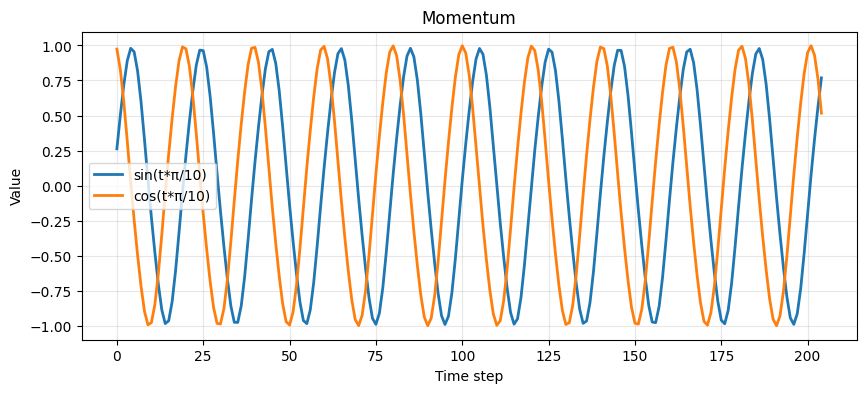

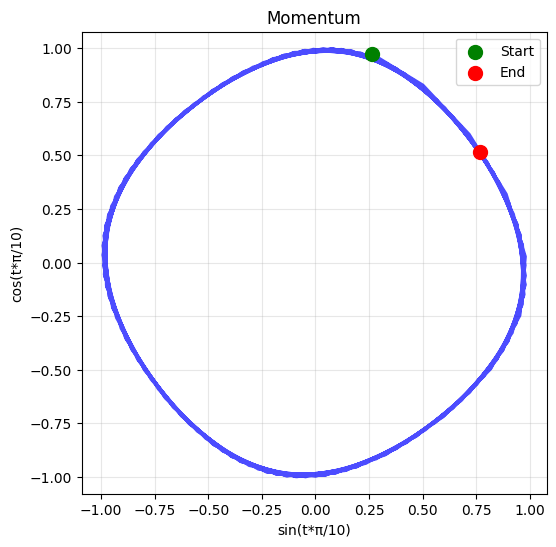

In [111]:
losses = train(model, learning_rate = 0.01, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
prediction_length = 5 * data.shape[0]
with tc.no_grad():
    # Initialize hidden state and predictions tensor
    h = tc.zeros(1, 1, model.latent_dim)
    predictions = tc.empty((prediction_length, 2))
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)
    
    # Generate sequence autoregressively, i.e. freely by providing the output as input
    for i in range(prediction_length):
        # TODO: make predictions and use prediction as input
        output, h = model(input_, h)  
        predictions[i] =  output
        input_ = output

# Plot the prediction data
plt.figure(figsize=(10, 4))
plt.plot(predictions[:,0], label='sin(t*π/10)', linewidth=2)
plt.plot(predictions[:,1], label='cos(t*π/10)', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title("Momentum")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(predictions[:,0], predictions[:,1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title("Momentum")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

### How does the adaptive learning rate of the Adam (Kingma and Ba, 2014) optimizer perform (torch.optim.Adam) in contrast to stochastic gradient descent (SGD)?

In [114]:
lossesSGD = train(model, learning_rate = 0.01, moment=0.9, optimizer_function='SGD', print_loss=False, batch_size=5, batch_sequence_length=5)
lossesADAM = train(model, learning_rate = 0.01, moment=0.9, optimizer_function='ADAM', print_loss=False, batch_size=5, batch_sequence_length=5)


Starting training for 1500 epochs...
Optimizer: SGD, LR: 0.01, Batch size: 5, Sequence length: 5

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 5, Sequence length: 5


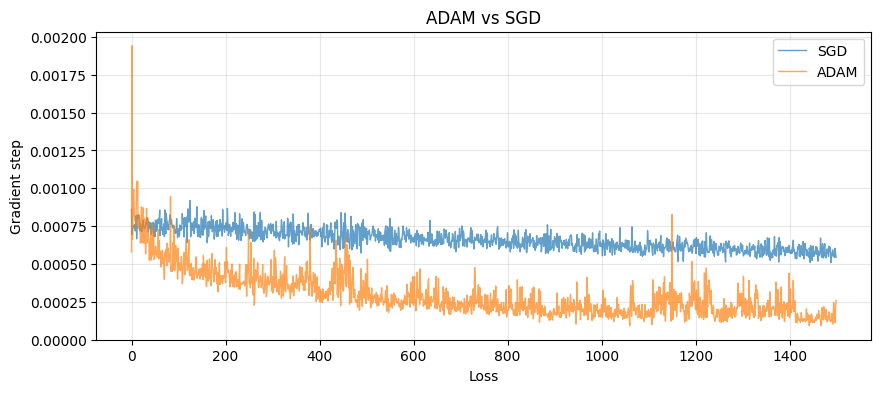

In [117]:
plt.figure(figsize=(10, 4))
plt.plot(range(len(losses)),lossesSGD, linewidth=1, alpha=0.7, label='SGD')
plt.plot(range(len(losses)),lossesADAM, linewidth=1, alpha=0.7, label='ADAM')
plt.xlabel('Loss')
plt.ylabel('Gradient step')
plt.title(f"ADAM vs SGD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ADAM seems to do better. 

### Can you identify bifurcations in the learning dynamics from eye-balling the loss curve? Plot the generated trajectories before and after a bifurcation to observe how the optimization changes the network dynamics